In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df=pd.read_csv('../df_normalized.csv')
df

,BMI,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,Hypertension,SystolicBP,DiastolicBP,CholesterolHDL,MMSE,FunctionalAssessment,MemoryComplaints,ADL,Confusion,Disorientation,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,0.316960,0.837564,0.0,0.0,1.0,1.0,0.0,0.584270,0.203390,0.171039,0.715606,0.652102,0.0,0.172486,0.0,0.0,1.0,0.0,0.0
1,0.473058,0.525021,0.0,0.0,0.0,0.0,0.0,0.280899,0.067797,0.738026,0.687251,0.712108,0.0,0.259154,0.0,0.0,0.0,1.0,0.0
2,0.111553,0.945597,1.0,0.0,0.0,0.0,0.0,0.101124,0.949153,0.622290,0.245145,0.589697,0.0,0.711936,0.0,1.0,1.0,0.0,0.0
3,0.752163,0.731994,0.0,0.0,0.0,0.0,0.0,0.314607,0.932203,0.605851,0.466410,0.896823,0.0,0.648094,0.0,0.0,0.0,0.0,0.0
4,0.228472,0.265892,0.0,0.0,0.0,0.0,0.0,0.044944,0.966102,0.461019,0.450619,0.604699,0.0,0.001341,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,0.965137,0.589092,0.0,0.0,0.0,0.0,0.0,0.359551,0.694915,0.511894,0.039881,0.023830,0.0,0.449224,1.0,0.0,0.0,0.0,1.0
2145,0.114035,0.759124,0.0,0.0,0.0,0.0,0.0,0.696629,0.779661,0.920845,0.215192,0.869049,0.0,0.920508,0.0,0.0,0.0,0.0,1.0
2146,0.018717,0.294609,0.0,0.0,0.0,0.0,0.0,0.280899,0.983051,0.996222,0.567120,0.197246,0.0,0.503582,0.0,0.0,0.0,0.0,1.0
2147,0.011650,0.720376,0.0,1.0,0.0,0.0,0.0,0.146067,0.610169,0.766192,0.134235,0.517550,0.0,0.378469,0.0,0.0,0.0,1.0,1.0


In [2]:
#S04T01 - Dividir os dados em conjuntos de treino, teste e validação (se necessário).

# Definindo atributo alvo 'Diagnosis'
X = df.drop(columns=['Diagnosis']) 
y = df['Diagnosis']  

# Dividir dados em treino (70%) e validação+teste (30%)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir dados de validação+teste em validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Tamanho das divisões
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de validação: {X_val.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (1504, 18)
Tamanho do conjunto de validação: (322, 18)
Tamanho do conjunto de teste: (323, 18)


Estratégia de Divisão dos Dados

Objetivo:

Dividir o conjunto de dados em três subconjuntos distintos: treinamento, validação e teste, com o objetivo de treinar, ajustar e avaliar o modelo de aprendizado de máquina de forma eficaz.

Justificativa:

Treinamento (70%): Usado para treinar o modelo, ou seja, para ajustar os parâmetros do modelo com base nos dados.

Validação (15%): Usado para ajustar hiperparâmetros do modelo e monitorar o desempenho durante o processo de treinamento. O conjunto de validação ajuda a evitar o overfitting.

Teste (15%): Usado para avaliar o desempenho final do modelo após o treinamento e a validação. O conjunto de teste é utilizado para verificar a generalização do modelo para dados nunca vistos.

Passos da Divisão

Divisão Inicial entre Treino e Restante (30%)
O primeiro passo é dividir os dados em duas partes: 70% para o conjunto de treinamento e 30% para o restante (que será dividido posteriormente entre validação e teste).

Função usada: train_test_split(X, y, test_size=0.3, random_state=42)

Parâmetros:

X: Conjunto de características (atributos).
y: Conjunto de rótulos (target).
test_size=0.3: 30% dos dados originais são alocados para o restante, que será dividido entre validação e teste.
random_state=42: Garantia de reprodutibilidade dos resultados, ou seja, sempre que o código for executado com esse valor, a divisão será a mesma.

Resultado:

X_train, y_train: Dados de treino (70% dos dados originais).
X_val_test, y_val_test: Dados restantes (30% dos dados originais, a serem divididos em validação e teste).

Divisão do Restante em Validação e Teste (50% / 50%)
O próximo passo é dividir o restante dos dados (30% do total) igualmente em validação e teste, de forma que cada conjunto tenha 15% do total de dados.


Função usada: train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

Parâmetros:

X_val_test: Conjunto restante de características (30% dos dados originais).
y_val_test: Conjunto restante de rótulos (30% dos dados originais).
test_size=0.5: A divisão é feita de forma que metade do conjunto restante vai para validação e a outra metade vai para teste (50% de 30% é 15% do total de dados).
random_state=42: Garantia de que a divisão seja reprodutível.

Resultado:

X_val, y_val: Dados de validação (15% dos dados originais).
X_test, y_test: Dados de teste (15% dos dados originais).


---

## Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
rf = RandomForestClassifier()

In [5]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [6]:
preds_rf = rf.predict(X_val)

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
accuracy_score(y_val, preds_rf)

0.8540372670807453

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
print(classification_report(y_val, preds_rf))

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88       180
         1.0       0.96      0.70      0.81       142

    accuracy                           0.85       322
   macro avg       0.88      0.84      0.85       322
weighted avg       0.87      0.85      0.85       322



- Recall: Nesse cenário, os alarmes falsos (FP) são de baixo custo, e os falsos negativos são muito caros. Portanto, faz sentido maximizar a recuperação ou a probabilidade de detecção. 
    - Essa é a métrica que queremos, pois é melhor priorizar a detecção de alzheimer mesmo dando alguns alarmes falsos (falso positivo) do que não detectar um alzheimer positivo (falso negativo)
    - Mas como da para ver, nosso recall é a métrica mais baixa agora pois está em 84%, isso era esperado visto que há muito mais caso negativo de alzheimer que positivo, logo o modelo está tendendo mais a dizer negativo, oque diminui o recall, por isso temos que mudar isso. 

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
rfParametros = {"max_features": ["sqrt", "log2", None], "criterion": ["gini", "entropy", "log_loss"]}
gs = GridSearchCV(estimator=rf, param_grid=rfParametros, verbose=3, scoring="recall", cv=5)
gs.fit(X_train, y_train)
print(gs.best_estimator_)
preds_rf2 = gs.best_estimator_.predict(X_val)
print(accuracy_score(y_val, preds_rf2))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .criterion=gini, max_features=sqrt;, score=0.817 total time=   0.2s
[CV 2/5] END .criterion=gini, max_features=sqrt;, score=0.796 total time=   0.2s
[CV 3/5] END .criterion=gini, max_features=sqrt;, score=0.777 total time=   0.2s
[CV 4/5] END .criterion=gini, max_features=sqrt;, score=0.748 total time=   0.2s
[CV 5/5] END .criterion=gini, max_features=sqrt;, score=0.728 total time=   0.2s
[CV 1/5] END .criterion=gini, max_features=log2;, score=0.788 total time=   0.2s
[CV 2/5] END .criterion=gini, max_features=log2;, score=0.796 total time=   0.2s
[CV 3/5] END .criterion=gini, max_features=log2;, score=0.786 total time=   0.2s
[CV 4/5] END .criterion=gini, max_features=log2;, score=0.748 total time=   0.2s
[CV 5/5] END .criterion=gini, max_features=log2;, score=0.718 total time=   0.2s
[CV 1/5] END .criterion=gini, max_features=None;, score=0.788 total time=   0.5s
[CV 2/5] END .criterion=gini, max_features=None;,

- Utilizado um GridSearchCV, para testar diferentes valores para 2 parâmetros diferentes, o max_features para determinar o número máximo de colunas usadas aleatoriamente, e o criterion que determina o tipo de calculo utilizado no Random Forest

In [13]:
print(classification_report(y_val, preds_rf2))

              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88       180
         1.0       0.95      0.71      0.81       142

    accuracy                           0.86       322
   macro avg       0.88      0.84      0.85       322
weighted avg       0.87      0.86      0.85       322



### Adicionando Oversampling

Para priorizar o Recall é necessário fazer um oversampling pois o dataset tende a dizer negativo (diagnóstico 0) pela quantidade de majoritária de 0 

In [14]:
# Bloco do Guilherme Cabreira
from imblearn.over_sampling import ADASYN

# Cria o objeto ADASYN
adasyn = ADASYN(random_state=42)

# Aplica o oversampling
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Verifica a nova distribuição das classes
print(y_resampled.value_counts())


Diagnosis
0.0    1389
1.0    1355
Name: count, dtype: int64


Foi testado a técnica de oversampling com SMOTE e ADASYN, para nosso caso o mais efetivo foi ADASYN

In [15]:
# Dividir dados em treino (70%) e validação+teste (30%)
X_train_r, X_val_test_r, y_train_r, y_val_test_r = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Dividir dados de validação+teste em validação (15%) e teste (15%)
X_val_r, X_test_r, y_val_r, y_test_r = train_test_split(X_val_test_r, y_val_test_r, test_size=0.5, random_state=42)

# Tamanho das divisões
print(f"Tamanho do conjunto de treino: {X_train_r.shape}")
print(f"Tamanho do conjunto de validação: {X_val_r.shape}")
print(f"Tamanho do conjunto de teste: {X_test_r.shape}")

Tamanho do conjunto de treino: (1920, 18)
Tamanho do conjunto de validação: (412, 18)
Tamanho do conjunto de teste: (412, 18)


In [16]:
gs.best_estimator_.fit(X_train_r, y_train_r)

RandomForestClassifier(criterion='entropy', max_features=None)

In [17]:
# Testando com os dados de validação
preds_rf3 = gs.best_estimator_.predict(X_val)

print(classification_report(y_val, preds_rf3))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       180
         1.0       0.96      0.92      0.94       142

    accuracy                           0.94       322
   macro avg       0.95      0.94      0.94       322
weighted avg       0.94      0.94      0.94       322



In [18]:
# Testando com os dados de teste final
preds_test_rf4 = gs.best_estimator_.predict(X_test)

print(classification_report(y_test, preds_test_rf4))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       221
         1.0       0.94      0.96      0.95       102

    accuracy                           0.97       323
   macro avg       0.96      0.97      0.96       323
weighted avg       0.97      0.97      0.97       323



Com Oversampling o recall ficou 91% e 96%, ou seja uma media de 93,5%, o que melhorou muito antes do Oversampling que era 70%. Porém a consequência foi que a precisão antes era 96% e agora 96% e 93%, ou seja uma média de 94%, então com Oversampling, a média aumentou mas a precisão diminiui um pouco, o que era esperado e justamente o que queríamos

## KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)

In [21]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [22]:
preds_knn = knn.predict(X_val)

In [23]:
print(classification_report(y_val, preds_knn))

              precision    recall  f1-score   support

         0.0       0.69      0.91      0.79       180
         1.0       0.81      0.49      0.61       142

    accuracy                           0.73       322
   macro avg       0.75      0.70      0.70       322
weighted avg       0.75      0.73      0.71       322



- Como da para ver, o KNN mesmo com normalização deu um resultado bem inferior ao random forest.

## LogisticRegression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [26]:
preds_lr = lr.predict(X_val)

In [27]:
print(classification_report(y_val, preds_lr))

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81       180
         1.0       0.82      0.61      0.70       142

    accuracy                           0.77       322
   macro avg       0.78      0.75      0.76       322
weighted avg       0.78      0.77      0.76       322



In [28]:
print(confusion_matrix(y_val, preds_lr))

[[161  19]
 [ 55  87]]


---

In [29]:
#S04T05 - Gerar gráficos de desempenho (matriz de confusão, curvas ROC).
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

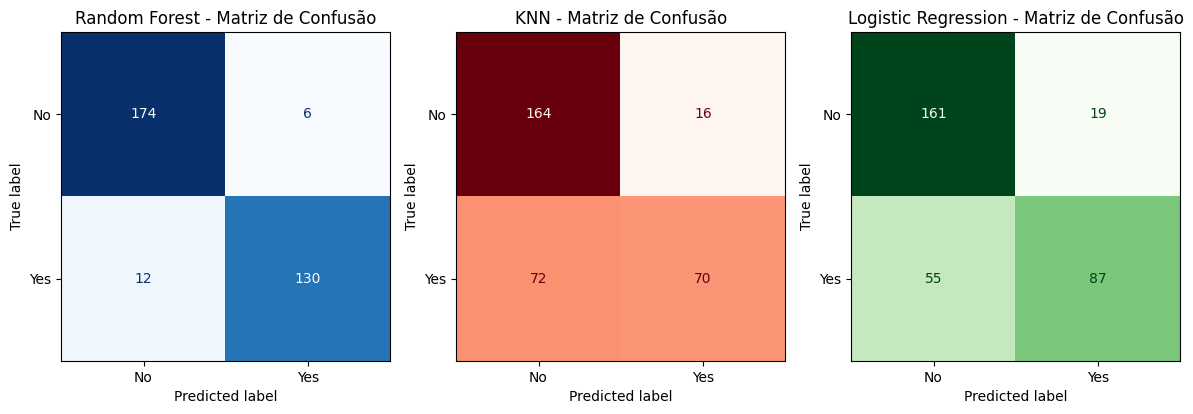

In [30]:
#S04T05 e S04T06 - matrizes de confusão (random forest comparada com logistic regression)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

conf_matrix_rf = confusion_matrix(y_val, preds_rf3)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=['No', 'Yes'])
disp_rf.plot(cmap='Blues', ax=ax[0], colorbar=False)
ax[0].set_title("Random Forest - Matriz de Confusão")

conf_matrix_rf = confusion_matrix(y_val, preds_knn)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=['No', 'Yes'])
disp_rf.plot(cmap='Reds', ax=ax[1], colorbar=False)
ax[1].set_title("KNN - Matriz de Confusão")

conf_matrix_lr = confusion_matrix(y_val, preds_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr, display_labels=['No', 'Yes'])
disp_lr.plot(cmap='Greens', ax=ax[2], colorbar=False)
ax[2].set_title("Logistic Regression - Matriz de Confusão")

plt.tight_layout()
plt.show()

In [31]:
#S04T05 - curvas ROC
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

roc_auc = roc_auc_score(y_val, y_probs)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.82
Accuracy: 0.77
Precision: 0.81
Recall: 0.61
F1 Score: 0.70
